### Ф-ия для определения формы тензора

In [1]:
Tensor = list

from typing import List

def shape(tensor: Tensor) -> List[int]:
    sizes: List[int] = []
    while isinstance(tensor, list):
        sizes.append(len(tensor))
        tensor = tensor[0]
    return sizes

assert shape([1, 2, 3]) == [3]
assert shape([[1, 2], [3, 4], [5, 6]]) == [3, 2]

In [2]:
def is_1d(tensor: Tensor) -> bool:
    """
    Если tensor[0] является списком, то это тензор более высокого порядка.
    В противном случае tensor является одномерным (вектором)
    """
    return not isinstance(tensor[0], list)

assert is_1d([1, 2, 3])
assert not is_1d([[1, 2], [3, 4]])

In [3]:
def tensor_sum(tensor: Tensor) -> float:
    """Суммирует все значения в тензоре"""
    if is_1d(tensor):
        return sum(tensor)  # Просто список вещественных, поэтому ф-ия sum
    else:
        return sum(tensor_sum(tensor_i)      # Вызвать tensor_sum на каждом ряду
                   for tensor_i in tensor)   # и просуммировать эти результаты

assert tensor_sum([1, 2, 3]) == 6
assert tensor_sum([[1, 2], [3, 4]]) == 10

### Вспомогательные ф-ии

#### Применяет f поэлементно

In [4]:
from typing import Callable

def tensor_apply(f: Callable[[float], float], tensor: Tensor) -> Tensor:
    """Применяет f поэлементно"""
    if is_1d(tensor):
        return [f(x) for x in tensor]
    else:
        return [tensor_apply(f, tensor_i) for tensor_i in tensor]

assert tensor_apply(lambda x: x + 1, [1, 2, 3]) == [2, 3, 4]
assert tensor_apply(lambda x: 2 * x, [[1, 2], [3, 4]]) == [[2, 4], [6, 8]]

#### Создает нулевой тензор той же формы

In [5]:
def zeros_like(tensor: Tensor) -> Tensor:
    return tensor_apply(lambda _: 0.0, tensor)

assert zeros_like([1, 2, 3]) == [0, 0, 0]
assert zeros_like([[1, 2], [3, 4]]) == [[0, 0], [0, 0]]

#### Применяет f к соответствующим элементам из двух тензоров

In [6]:
def tensor_combine(f: Callable[[float, float], float],
                   t1: Tensor,
                   t2: Tensor) -> Tensor:
    """Применяет f к соответствующим элементам из двух тензоров t1 и t2"""
    if is_1d(t1):
        return [f(x, y) for x, y in zip(t1, t2)]
    else:
        return [tensor_combine(f, t1_i, t2_i)
                for t1_i, t2_i in zip(t1, t2)]

import operator
assert tensor_combine(operator.add, [1, 2, 3], [4, 5, 6]) == [5, 7, 9]
assert tensor_combine(operator.mul, [1, 2, 3], [4, 5, 6]) == [4, 10, 18]

### Абстракция слоя

In [7]:
from typing import Iterable, Tuple

class Layer:
    """
    Наши нейронные сети будут состоять из слоев, каждый из которых
    знает, как выполнять некоторые вычисления на своих входах
    в "прямом" направлении и распространять градиенты
    в "обратном" направлении
    """
    def forward(self, input):
        """
        Следует обратить внимание на отсутствие типов.
        Мы не будем предписывать, какие типы входов слои могут
        принимать и какие виды выходов они могут возвращать
        """
        raise NotImplementedError

    def backward(self, gradient):
        """
        Точно так же мы не будем предписывать, как выглядит градиент.
        В ваших обязанностях следить за тем, что вы все делаете разумно
        """
        raise NotImplementedError

    def params(self) -> Iterable[Tensor]:
        """
        Возвращает параметры этого слоя. Дефолтная имплементация
        ничего не возвращает, так что если у вас есть слой без
        параметров, то вам не нужно его имплементировать
        """
        return ()

    def grads(self) -> Iterable[Tensor]:
        """
        Возвращает градиенты в том же порядке, что и params()
        """
        return ()


#### Слой sigmoid


In [8]:
from theory.neural_networks import sigmoid

class Sigmoid(Layer):
    def forward(self, input: Tensor) -> Tensor:
        """
        Apply sigmoid to each element of the input tensor,
        and save the results to use in backpropagation.
        """
        self.sigmoids = tensor_apply(sigmoid, input)
        return self.sigmoids

    def backward(self, gradient: Tensor) -> Tensor:
        return tensor_combine(lambda sig, grad: sig * (1 - sig) * grad,
                              self.sigmoids,
                              gradient)


0 [1.634287973318611, 7.99901254982857, 0.09186237402084903]
1 [1.6016022138522388, 7.839032298831999, 0.09002512654043204]
2 [1.569570169575194, 7.682251652855359, 0.0882246240096234]
3 [1.53817876618369, 7.528606619798252, 0.08646013152943094]
4 [1.5074151908600162, 7.378034487402287, 0.08473092889884232]
5 [1.4772668870428158, 7.230473797654241, 0.08303631032086548]
6 [1.4477215493019595, 7.085864321701156, 0.08137558411444816]
7 [1.4187671183159203, 6.944147035267133, 0.0797480724321592]
8 [1.3903917759496018, 6.805264094561791, 0.07815311098351602]
9 [1.3625839404306097, 6.669158812670555, 0.0765900487638457]
10 [1.3353322616219976, 6.535775636417144, 0.07505824778856879]
11 [1.3086256163895575, 6.405060123688801, 0.07355708283279741]
12 [1.2824531040617664, 6.276958921215025, 0.07208594117614146]
13 [1.256804041980531, 6.151419742790725, 0.07064422235261864]
14 [1.2316679611409205, 6.02839134793491, 0.06923133790556626]
15 [1.207034601918102, 5.907823520976212, 0.0678467111474549

fizz buzz (loss: 87.51): 100%|██████████| 500/500 [01:34<00:00,  5.27it/s] 

1 1 1
2 2 2
3 fizz fizz
4 4 4
5 5 buzz
6 fizz fizz
7 7 7
8 fizz 8
9 fizz fizz
10 buzz buzz
11 11 11
12 fizz fizz
13 13 13
14 14 14
15 fizzbuzz fizzbuzz
16 16 16
17 17 17
18 fizz fizz
19 19 19
20 20 buzz
21 fizz fizz
22 22 22
23 23 23
24 fizz fizz
25 buzz buzz
26 26 26
27 fizz fizz
28 28 28
29 29 29
30 fizzbuzz fizzbuzz
31 31 31
32 32 32
33 fizz fizz
34 34 34
35 buzz buzz
36 fizz fizz
37 37 37
38 38 38
39 fizz fizz
40 buzz buzz
41 41 41
42 fizz fizz
43 43 43
44 44 44
45 fizzbuzz fizzbuzz
46 46 46
47 47 47
48 fizz fizz
49 49 49
50 buzz buzz
51 fizz fizz
52 52 52
53 53 53
54 fizz fizz
55 buzz buzz
56 56 56
57 fizz fizz
58 58 58
59 59 59
60 fizzbuzz fizzbuzz
61 61 61
62 62 62
63 fizz fizz
64 64 64
65 65 buzz
66 fizz fizz
67 67 67
68 68 68
69 fizz fizz
70 buzz buzz
71 71 71
72 fizz fizz
73 73 73
74 74 74
75 fizzbuzz fizzbuzz
76 76 76
77 fizz 77
78 fizz fizz
79 79 79
80 buzz buzz
81 fizz fizz
82 82 82
83 83 83
84 fizz fizz
85 fizz buzz
86 86 86
87 fizz fizz
88 88 88
89 89 89
90 fizzbuzz fizz

### Линейный слой

In [9]:
import random

from theory.probability import inverse_normal_cdf

def random_uniform(*dims: int) -> Tensor:
    if len(dims) == 1:
        return [random.random() for _ in range(dims[0])]
    else:
        return [random_uniform(*dims[1:]) for _ in range(dims[0])]

def random_normal(*dims: int,
                  mean: float = 0.0,
                  variance: float = 1.0) -> Tensor:
    if len(dims) == 1:
        return [mean + variance * inverse_normal_cdf(random.random())
                for _ in range(dims[0])]
    else:
        return [random_normal(*dims[1:], mean=mean, variance=variance)
                for _ in range(dims[0])]

assert shape(random_uniform(2, 3, 4)) == [2, 3, 4]
assert shape(random_normal(5, 6, mean=10)) == [5, 6]

<Figure size 640x480 with 0 Axes>

In [10]:
def random_tensor(*dims: int, init: str = 'normal') -> Tensor:
    if init == 'normal':
        return random_normal(*dims)
    elif init == 'uniform':
        return random_uniform(*dims)
    elif init == 'xavier':
        variance = len(dims) / sum(dims)
        return random_normal(*dims, variance=variance)
    else:
        raise ValueError(f"unknown init: {init}")

In [11]:
from theory.linear_algebra import dot

class Linear(Layer):
    def __init__(self, input_dim: int, output_dim: int, init: str = 'xavier') -> None:
        """
        Слой из output_dim нейронов с input_dim весами каждый(и bias)
        """
        self.input_dim = input_dim
        self.output_dim = output_dim

        # self.w[o] это веса для 0-го нейрона
        self.w = random_tensor(output_dim, input_dim, init=init)

        # self.b[o] это член смещения для 0-го нейрона
        self.b = random_tensor(output_dim, init=init)

    def forward(self, input: Tensor) -> Tensor:
        # Сохранить вход для использования в обратном прохождении
        self.input = input

        # Вернуть вектор выходов нейронов
        return [dot(input, self.w[o]) + self.b[o]
                for o in range(self.output_dim)]

    def backward(self, gradient: Tensor) -> Tensor:
        # Каждый b[o] добавляется в output[o], т.е.
        # градиент b тот же самый, что и градиент выхода
        self.b_grad = gradient

        # Каждый w[o][i] умножает input[i] и добавляется в output[o].
        # Поэтому его градиент равен input[i] * gradient[o].
        self.w_grad = [[self.input[i] * gradient[o]
                        for i in range(self.input_dim)]
                       for o in range(self.output_dim)]

        # Каждый input[i] умножает каждый w[o][i] и добавляется в каждый
        # output[o]. Поэтому его градиент равен сумме w[o][i] * gradient[o]
        # по всем выходам.
        return [sum(self.w[o][i] * gradient[o] for o in range(self.output_dim))
                for i in range(self.input_dim)]

    def params(self) -> Iterable[Tensor]:
        return [self.w, self.b]

    def grads(self) -> Iterable[Tensor]:
        return [self.w_grad, self.b_grad]


## Нейронные сети как последовательность слоев

In [12]:
from typing import List

class Sequential(Layer):
    """Слой, состоящий из последовательности других слоев.
       Вы обязаны следить за тем, чтобы выход каждого слоя
       имел смысл в качестве входа в следующий слой"""
    def __init__(self, layers: List[Layer]) -> None:
        self.layers = layers

    def forward(self, input):
        """Распространить вход вперед через слои по порядку"""
        for layer in self.layers:
            input = layer.forward(input)
        return input

    def backward(self, gradient):
        """Распространить градиент назад через слои в универсуме"""
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient)
        return gradient

    def params(self) -> Iterable[Tensor]:
        """Вернуть params из каждого слоя"""
        return (param for layer in self.layers for param in layer.params())

    def grads(self) -> Iterable[Tensor]:
        """Вернуть grads из каждого слоя"""
        return (grad for layer in self.layers for grad in layer.grads())

### Потери

In [13]:
class Loss:
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        """На сколько хорошим является предсказание? (Чем крупнее, тем хуже)"""
        raise NotImplementedError

    def gradient(self, predicted: Tensor, actual: Tensor) -> Tensor:
        """Как изменяется потеря при изменении предсказаний?"""
        raise NotImplementedError

In [14]:
class SSE(Loss):
    """Функция потери, которая вычисляет сумму квадратов ошибок"""
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        # Вычислить тензор квадратических разностей
        squared_errors = tensor_combine(
            lambda predicted, actual: (predicted - actual) ** 2,
            predicted,
            actual)

        # И просто сложить их
        return tensor_sum(squared_errors)

    def gradient(self, predicted: Tensor, actual: Tensor) -> Tensor:
        return tensor_combine(
            lambda predicted, actual: 2 * (predicted - actual),
            predicted,
            actual)


sse_loss = SSE()
assert sse_loss.loss([1, 2, 3], [10, 20, 30]) == 9 ** 2 + 18 ** 2 + 27 ** 2
assert sse_loss.gradient([1, 2, 3], [10, 20, 30]) == [-18, -36, -54]

### Оптимизатор

In [15]:
class Optimizer:
    """
    Оптимизатор обновляет веса слоя (прямо на месте), используя
    информацию, известную либо слою, либо оптимизатору (либо обоим)
    """
    def step(self, layer: Layer) -> None:
        raise NotImplementedError

### Градиентный спуск

In [16]:
class GradientDescent(Optimizer):
    def __init__(self, learning_rate: float = 0.1) -> None:
        self.lr = learning_rate

    def step(self, layer: Layer) -> None:
        for param, grad in zip(layer.params(), layer.grads()):
            # Обновить param, используя градинтный шаг
            param[:] = tensor_combine(
                lambda param, grad: param - grad * self.lr,
                param,
                grad)

### Просто пример, объясняющий почему [:]

In [17]:
tensor = [[1, 2], [3, 4]]

for row in tensor:
    row = [0, 0]
assert tensor == [[1, 2], [3, 4]], "Присвоение не обновляет список"

for row in tensor:
    row[:] = [0, 0]
assert tensor == [[0, 0], [0, 0]], "Но присвоение срезу это делает"

### Оптимизатор, использующий импульс

In [18]:
class Momentum(Optimizer):
    def __init__(self,
                 learning_rate: float,
                 momentum: float = 0.9) -> None:
        self.lr = learning_rate
        self.mo = momentum
        self.updates: List[Tensor] = []  # Скользящее среднее

    def step(self, layer: Layer) -> None:
        # Если у нас нет предыдущих обновлений, то начать со всех нулей
        if not self.updates:
            self.updates = [zeros_like(grad) for grad in layer.grads()]

        for update, param, grad in zip(self.updates,
                                       layer.params(),
                                       layer.grads()):
            # Применить импульс
            update[:] = tensor_combine(
                lambda u, g: self.mo * u + (1 - self.mo) * g,
                update,
                grad)

            # TЗатем сделать градиентный шаг
            param[:] = tensor_combine(
                lambda p, u: p - self.lr * u,
                param,
                update)

#### Пример: сеть XOR

In [19]:
# Тренировочные данные
xs = [[0., 0], [0., 1], [1., 0], [1., 1]]
ys = [[0.], [1.], [1.], [0.]]

In [20]:
random.seed(0)
    
net = Sequential([
    Linear(input_dim=2, output_dim=2),
    Sigmoid(),
    Linear(input_dim=2, output_dim=1)
])

### тренировочный цикл

In [21]:
import tqdm
    
optimizer = GradientDescent(learning_rate=0.1)
loss = SSE()
    
with tqdm.trange(3000) as t:
    for epoch in t:
        epoch_loss = 0.0
    
        for x, y in zip(xs, ys):
            predicted = net.forward(x)
            epoch_loss += loss.loss(predicted, y)
            gradient = loss.gradient(predicted, y)
            net.backward(gradient)
    
            optimizer.step(net)
    
        t.set_description(f"xor loss {epoch_loss:.3f}")

xor loss 0.000: 100%|██████████| 3000/3000 [00:01<00:00, 1833.44it/s]


In [22]:
for param in net.params():
        print(param)

[[-1.6425160695224112, -1.4948117798303162], [-4.567646572029666, -3.3649176350731915]]
[1.7673716823255192, 0.3872701437947276]
[[3.1986204791704025, -3.5018030621426206]]
[-0.64627659633622]


## Другие активационные функции

### Гиперболический тангенс (tanh)

In [23]:
import math

def tanh(x: float) -> float:
    # Если x является очень большим или очень малым,
    # то tanh (по существу) равен 1 или -1.
    # Мы делаем проверку этого, потому что,
    # например, math.exp(1000) вызывает ошибку
    if x < -100:  return -1
    elif x > 100: return 1

    em2x = math.exp(-2 * x)
    return (1 - em2x) / (1 + em2x)

class Tanh(Layer):
    def forward(self, input: Tensor) -> Tensor:
        # Сохранить выход tanh для использования в обратном прохождении
        self.tanh = tensor_apply(tanh, input)
        return self.tanh

    def backward(self, gradient: Tensor) -> Tensor:
        return tensor_combine(
            lambda tanh, grad: (1 - tanh ** 2) * grad,
            self.tanh,
            gradient)

### Функция Relu

In [24]:
class Relu(Layer):
    def forward(self, input: Tensor) -> Tensor:
        self.input = input
        return tensor_apply(lambda x: max(x, 0), input)

    def backward(self, gradient: Tensor) -> Tensor:
        return tensor_combine(lambda x, grad: grad if x > 0 else 0,
                              self.input,
                              gradient)

## Пример: задача Fizz Buzz

### настроим данные

In [25]:
from theory.neural_networks import binary_encode, fizz_buzz_encode, argmax
    
xs = [binary_encode(n) for n in range(101, 1024)]
ys = [fizz_buzz_encode(n) for n in range(101, 1024)]

### создадим сеть

In [26]:
NUM_HIDDEN = 25
    
random.seed(0)
    
net = Sequential([
    Linear(input_dim=10, output_dim=NUM_HIDDEN, init='uniform'),
    Tanh(),
    Linear(input_dim=NUM_HIDDEN, output_dim=4, init='uniform'),
    Sigmoid()
])

### Отслеживаем нашу точность на тренировочном наборе

In [27]:
def fizzbuzz_accuracy(low: int, hi: int, net: Layer) -> float:
        num_correct = 0
        for n in range(low, hi):
            x = binary_encode(n)
            predicted = argmax(net.forward(x))
            actual = argmax(fizz_buzz_encode(n))
            if predicted == actual:
                num_correct += 1
    
        return num_correct / (hi - low)

optimizer = Momentum(learning_rate=0.1, momentum=0.9)
loss = SSE()

with tqdm.trange(1000) as t:
        for epoch in t:
            epoch_loss = 0.0
    
            for x, y in zip(xs, ys):
                predicted = net.forward(x)
                epoch_loss += loss.loss(predicted, y)
                gradient = loss.gradient(predicted, y)
                net.backward(gradient)
    
                optimizer.step(net)
    
            accuracy = fizzbuzz_accuracy(101, 1024, net)
            t.set_description(f"fb loss: {epoch_loss:.2f} acc: {accuracy:.2f}")
    
    # Теперь проверим результаты на тестовом наборе
print("Тестовые результаты", fizzbuzz_accuracy(1, 101, net))

fb loss: 64.51 acc: 0.95: 100%|██████████| 1000/1000 [04:42<00:00,  3.55it/s]

Тестовые результаты 0.9


## Функции softmax и перекрестная энтропия

In [28]:
def softmax(tensor: Tensor) -> Tensor:
    """Взять Softmax вдоль последней размерности"""
    if is_1d(tensor):
        # Вычесть наибольшее значение в целях числовой стабильности
        largest = max(tensor)
        exps = [math.exp(x - largest) for x in tensor]

        sum_of_exps = sum(exps)                 # Это суммарный "вес".
        return [exp_i / sum_of_exps             # Вероятность - это доля
                for exp_i in exps]              # суммарного веса
    else:
        return [softmax(tensor_i) for tensor_i in tensor]

In [29]:
class SoftmaxCrossEntropy(Loss):
    """
    Отрицательное логарифмическое правдоподобие наблюдаемых значений
    при наличии нейросетевой модели. Поэтому, если мы выберем веса
    для ее минимизации, то наша модель будет максимизировать
    правдоподобие наблюдаемых данных
    """
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        # Применить softmax, чтобы получить вероятности
        probabilities = softmax(predicted)

        # Это будет логарифм p_i для фактического класса i
        # и 0 для других классов. Мы добавляем крошечное значение
        # в p во избежание взятия log(0)
        likelihoods = tensor_combine(lambda p, act: math.log(p + 1e-30) * act,
                                     probabilities,
                                     actual)

        # И затем просто просуммировать отрицательные значения
        return -tensor_sum(likelihoods)

    def gradient(self, predicted: Tensor, actual: Tensor) -> Tensor:
        probabilities = softmax(predicted)

        # Разве это не прияное уравнение?
        return tensor_combine(lambda p, actual: p - actual,
                              probabilities,
                              actual)

### Fizz Buzz, но с sofmax

In [30]:
random.seed(0)
    
net = Sequential([
    Linear(input_dim=10, output_dim=NUM_HIDDEN, init='uniform'),
    Tanh(),
    Linear(input_dim=NUM_HIDDEN, output_dim=4, init='uniform')
        # Теперь нет завершающего сигмоидального слоя
])
    
optimizer = Momentum(learning_rate=0.1, momentum=0.9)
loss = SoftmaxCrossEntropy()
    
with tqdm.trange(100) as t:
    for epoch in t:
        epoch_loss = 0.0
    
        for x, y in zip(xs, ys):
            predicted = net.forward(x)
            epoch_loss += loss.loss(predicted, y)
            gradient = loss.gradient(predicted, y)
            net.backward(gradient)
    
            optimizer.step(net)
    
        accuracy = fizzbuzz_accuracy(101, 1024, net)
        t.set_description(f"fb loss: {epoch_loss:.3f} acc: {accuracy:.2f}")
    
# Снова проверим результаты на тестовом наборе
print("test results", fizzbuzz_accuracy(1, 101, net))

fb loss: 5.229 acc: 1.00: 100%|██████████| 100/100 [00:27<00:00,  3.61it/s]  

test results 0.95


## Слой отсева

In [31]:
class Dropout(Layer):
    def __init__(self, p: float) -> None:
        self.p = p
        self.train = True

    def forward(self, input: Tensor) -> Tensor:
        if self.train:
            # Создать маску из нулей и единиц с формой, что и вход
            # используя указанную вероятность 
            self.mask = tensor_apply(
                lambda _: 0 if random.random() < self.p else 1,
                input)
            # Умножить на маску для отсева входов
            return tensor_combine(operator.mul, input, self.mask)
        else:
            # Во время оценивания просто прошкалировать выходы равномерно
            return tensor_apply(lambda x: x * (1 - self.p), input)

    def backward(self, gradient: Tensor) -> Tensor:
        if self.train:
            # Распространить градиенты только там, где mask == 1
            return tensor_combine(operator.mul, gradient, self.mask)
        else:
            raise RuntimeError("Не вызывайте backward в тренировочном режиме")

## Пример: набор данных MNIST

### Загружаем данные

In [33]:
import mnist

mnist.temporary_dir = lambda: 'tmp'

# Обе ф-ии сначала скачивают данные, а затем возвращают массив NumPy
# мы вызываем .tolist (), потому что "тензоры" - это просто списки
train_images = mnist.train_images().tolist()
train_labels = mnist.train_labels().tolist()

assert shape(train_images) == [60000, 28, 28]
assert shape(train_labels) == [60000]

HTTPError: HTTP Error 404: Not Found

### Выведем первые 100 тренировочных изображений на график

NameError: name 'train_images' is not defined

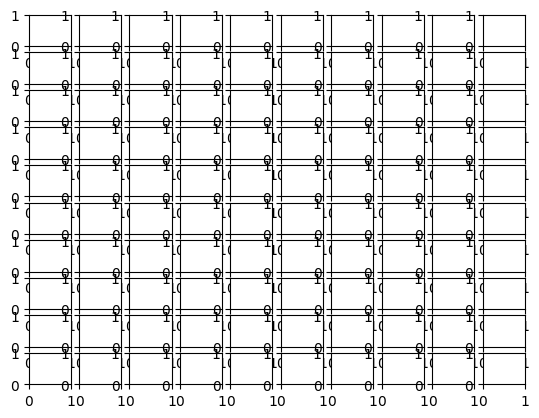

In [ ]:
import matplotlib.pyplot as plt
    
fig, ax = plt.subplots(10, 10)
    
for i in range(10):
    for j in range(10):
        # Изобразить каждый снимок в черно-белом цвете и спрятать оси
        ax[i][j].imshow(train_images[10 * i + j], cmap='Greys')
        ax[i][j].xaxis.set_visible(False)
        ax[i][j].yaxis.set_visible(False)
    
plt.show()

### Загрузим тестовые изображения

In [ ]:
test_images = mnist.test_images().tolist()
test_labels = mnist.test_labels().tolist()

assert shape(test_images) == [10000, 28, 28]
assert shape(test_labels) == [10000]

TimeoutError: [WinError 10060] Попытка установить соединение была безуспешной, т.к. от другого компьютера за требуемое время не получен нужный отклик, или было разорвано уже установленное соединение из-за неверного отклика уже подключенного компьютера

### Вычислить среднее пиксельное значение

In [ ]:
avg = tensor_sum(train_images) / 60000 / 28 / 28
    
# Перецентрировать, перешкалировать и сгладить
train_images = [[(pixel - avg) / 256 for row in image for pixel in row]
                for image in train_images]
test_images = [[(pixel - avg) / 256 for row in image for pixel in row]
                for image in test_images]
    
assert shape(train_images) == [60000, 784], "images should be flattened"
assert shape(test_images) == [10000, 784], "images should be flattened"
    
# После центрирования средний пиксел должен варьироваться очень близко к 0
assert -0.0001 < tensor_sum(train_images) < 0.0001

NameError: name 'train_images' is not defined

### One-hot encode

In [ ]:
def one_hot_encode(i: int, num_labels: int = 10) -> List[float]:
    return [1.0 if j == i else 0.0 for j in range(num_labels)]

assert one_hot_encode(3) == [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
assert one_hot_encode(2, num_labels=5) == [0, 0, 1, 0, 0]

### Применим к нашим данным one-hot

In [ ]:
train_labels = [one_hot_encode(label) for label in train_labels]
test_labels = [one_hot_encode(label) for label in test_labels]
    
assert shape(train_labels) == [60000, 10]
assert shape(test_labels) == [10000, 10]

### Training loop

In [1]:
import tqdm
    
def loop(model: Layer,
        images: List[Tensor],
        labels: List[Tensor],
        loss: Loss,
        optimizer: Optimizer = None) -> None:
    correct = 0         # Отслеживать число правильных предсказаний
    total_loss = 0.0    # Отслеживать суммарную потерю
    
    with tqdm.trange(len(images)) as t:
        for i in t:
            predicted = model.forward(images[i])             # Предсказать
            if argmax(predicted) == argmax(labels[i]):       # Проверить на
                correct += 1                                 # правильность
            total_loss += loss.loss(predicted, labels[i])    # Вычислить потерю.
    
            # Мы тренируем, распространяем гардиент по сети назад и обновляем веса
            if optimizer is not None:
                gradient = loss.gradient(predicted, labels[i])
                model.backward(gradient)
                optimizer.step(model)
    
            # И обновить наши метрики в индикаторе выполнения
            avg_loss = total_loss / (i + 1)
            acc = correct / (i + 1)
            t.set_description(f"mnist loss: {avg_loss:.3f} acc: {acc:.3f}")

NameError: name 'Layer' is not defined

### Логистическая регрессия для MNIST

In [ ]:
random.seed(0)
    
# Логистическая регрессия - это просто линейный слой,
# за которым следует softmax
model = Linear(784, 10)
loss = SoftmaxCrossEntropy()
    
# Этот оптимизатор, похоже, справляется
optimizer = Momentum(learning_rate=0.01, momentum=0.99)
    
# Натренировать на тренировочных данных
loop(model, train_images, train_labels, loss, optimizer)
    
# Протестировать на тестовых данных
# (отсутсвие оптимизатора означает просто оценивание)
loop(model, test_images, test_labels, loss)

### DL для MNIST

In [ ]:
random.seed(0)
    
# Дадим им имена, чтобы можно было включать/выключать тренировку
dropout1 = Dropout(0.1)
dropout2 = Dropout(0.1)
    
model = Sequential([
    Linear(784, 30),  # Скрытый слой 1: размер 30
    dropout1,
    Tanh(),
    Linear(30, 10),   # Скрытый слой 2: размер 10
    dropout2,
    Tanh(),
    Linear(10, 10)    # Выходной слой: размер 10
])

### Тренировка

In [ ]:
optimizer = Momentum(learning_rate=0.01, momentum=0.99)
loss = SoftmaxCrossEntropy()
    
# Включить отсев и тренировать 
dropout1.train = dropout2.train = True
loop(model, train_images, train_labels, loss, optimizer)
    
# Отключить отсев и оценить
dropout1.train = dropout2.train = False
loop(model, test_images, test_labels, loss)

### Сохраняем модель

In [ ]:
import json

def save_weights(model: Layer, filename: str) -> None:
    weights = list(model.params())
    with open(filename, 'w') as f:
        json.dump(weights, f)

### Загрузка весов

In [ ]:
def load_weights(model: Layer, filename: str) -> None:
    with open(filename) as f:
        weights = json.load(f)

    # Проверить на непротиворечивость
    assert all(shape(param) == shape(weight)
               for param, weight in zip(model.params(), weights))

    # Затем загрузить, применив срезовое присвоение
    for param, weight in zip(model.params(), weights):
        param[:] = weight